<a href="https://colab.research.google.com/github/colinchu1/CAP4630/blob/master/HW4/HW_4(problem3_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You will adapt the notebook using VGG16 conv base for feature extraction, using data augmentation, not using dropout, fine-tuning. You will have to replace the VGG16 conv base by new conv bases. You should not use VGG19.

You should create two notebooks. Both should use the same conv base, unfreeze the same number of layers of the conv_base, but use different classifiers.

##Download Data
Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in /tmp.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-22 02:17:24--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  99.9MB/s    in 0.7s    

2020-04-22 02:17:24 (99.9 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

##Build network with MobileNetV2 convolution base and custom densely connected layers

###Load the convolutional base

In [4]:
from keras.applications import MobileNetV2

conv_base = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


###Freeze the convolutional base

In [0]:
conv_base.trainable = False

###Concatenate the convolutional base and densely connected layers

I added a maxpooling layer since it helps with classifiying image, and another dense layer

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1310976   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#Train the model end to end with frozen convolutional base

This note book will be changing the classifier using max pooling(a layer helps trying to classifying images) and another dense layer



In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 26s 261ms/step - loss: 0.6204 - acc: 0.6960 - val_loss: 0.6471 - val_acc: 0.8720
Epoch 2/30
100/100 [==============================] - 16s 163ms/step - loss: 0.4263 - acc: 0.8010 - val_loss: 0.8128 - val_acc: 0.8730
Epoch 3/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3932 - acc: 0.8230 - val_loss: 1.0691 - val_acc: 0.8840
Epoch 4/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3694 - acc: 0.8305 - val_loss: 0.0884 - val_acc: 0.8920
Epoch 5/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3248 - acc: 0.8650 - val_loss: 0.4591 - val_acc: 0.9100
Epoch 6/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3224 - acc: 0.8615 - val_loss: 0.0704 - val_acc: 0.9090
Epoch 7/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3131 - acc: 0.8655 - val_loss: 0.3261 - val_acc: 0.9170
Epoch 8/30
100/100 [==============================] - 1

#Display curves of loss and accuracy during training

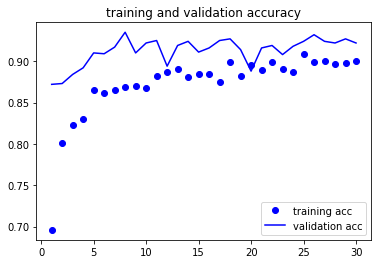

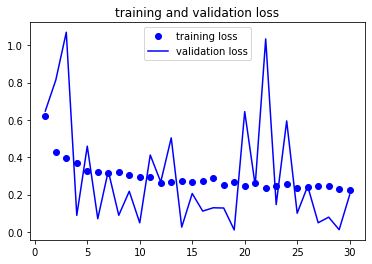

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

#Fine-tuning
### I chose to unfreeze block_5_expand in mobilenetV2

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block_5_expand':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [15]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 27s 271ms/step - loss: 0.2211 - acc: 0.9125 - val_loss: 0.1168 - val_acc: 0.9400
Epoch 2/30
100/100 [==============================] - 19s 188ms/step - loss: 0.2221 - acc: 0.9190 - val_loss: 0.0210 - val_acc: 0.9520
Epoch 3/30
100/100 [==============================] - 19s 189ms/step - loss: 0.2187 - acc: 0.9075 - val_loss: 0.0075 - val_acc: 0.9560
Epoch 4/30
100/100 [==============================] - 19s 190ms/step - loss: 0.1757 - acc: 0.9275 - val_loss: 0.0285 - val_acc: 0.9590
Epoch 5/30
100/100 [==============================] - 19s 192ms/step - loss: 0.1808 - acc: 0.9285 - val_loss: 0.3649 - val_acc: 0.9640
Epoch 6/30
100/100 [==============================] - 19s 189ms/step - loss: 0.1708 - acc: 0.9310 - val_loss: 0.0921 - val_acc: 0.9620
Epoch 7/30
100/100 [==============================] - 19s 188ms/step - loss: 0.1657 - acc: 0.9315 - val_loss: 0.1974 - val_acc: 0.9610
Epoch 8/30
100/100 [==============================] - 1

#Display learning curves during fine-tuning

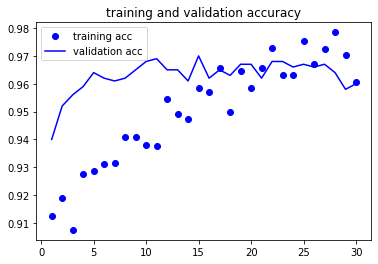

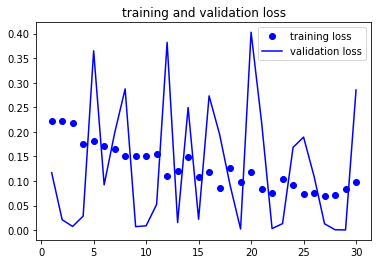

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

the validation loss fluctuating, probably caused by high learning rate, The accuracy have a definite increase compare to before fine tuning. seems like average about 96% while the old one is about 90%

#Print out validation loss and accuracy 

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [18]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.11388120800256729
Validation accuracy: 0.9599999785423279


#Save the model

In [19]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
